In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/CC_Thesis_DP/datasets/imagenet/Siamese.zip", 'r')
for i in range(631168):

  zip_ref.extract(zip_ref.infolist()[i], path = "/content/imagenet/")

#zip_ref.extractall("/content/CC_Thesis_DP/datasets/imagenet/")
zip_ref.close()

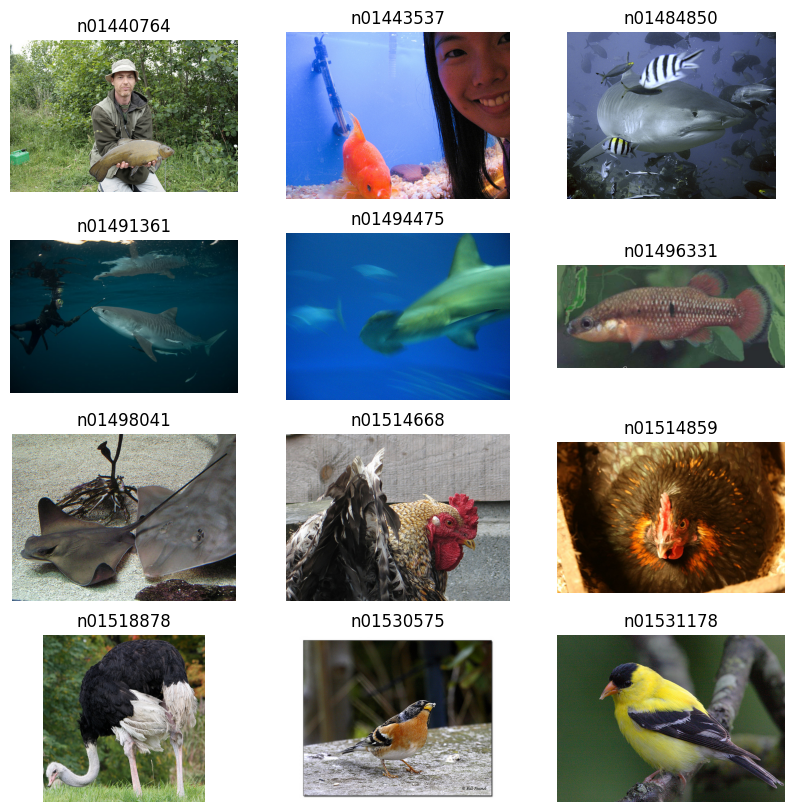

In [ ]:
# prompt: Show some image from each class

import glob
import matplotlib.pyplot as plt
from PIL import Image
import random

# Get a list of all the image files in the dataset.
images = glob.glob('/content/imagenet/Siamese/*/*.JPEG')

# Create a figure with subplots to display the images.
fig, axs = plt.subplots(4, 3, figsize=(10, 10))

# Select a random image from each class and display it.
ids = sorted(set([image.split('/')[-1][image.split('/')[-1].find('_n')+1:image.split('/')[-1].find('_n')+10] for image in images]))
for i, cls in enumerate(ids[0:12]):
  class_images = [image for image in images if image.split('/')[-1][image.split('/')[-1].find('_n')+1:image.split('/')[-1].find('_n')+10] == cls]
  random_image = random.choice(class_images)
  image = Image.open(random_image)
  axs[i // 3, i % 3].imshow(image)
  axs[i // 3, i % 3].set_title(cls)
  axs[i // 3, i % 3].axis('off')

# Show the plot.
plt.show()

In [ ]:
# Download ImageNet synset information and process it

#!wget https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/d25516d26be4a8d3e0aeebe9275631754b8e2c73/imagenet_label_to_wordnet_synset.txt -P /content/imagenet

#!pip install pyyaml
import yaml

with open("/content/drive/MyDrive/CC_Thesis_DP/datasets/imagenet/imagenet_label_to_wordnet_synset.txt", 'r') as stream:
  data = yaml.safe_load(stream)

id_to_label = {}
id_to_cls = {}
for i in data:
    entry = data[i]
    id = entry['id'].split('-')[1] + entry['id'].split('-')[0]
    label = entry['label']
    id_to_label[id] = label
    id_to_cls[id] = i

for id in ids:
    print(id, id_to_label[id])


n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus
n01530575 brambling, Fringilla montifringilla
n01531178 goldfinch, Carduelis carduelis
n01532829 house finch, linnet, Carpodacus mexicanus
n01534433 junco, snowbird
n01537544 indigo bunting, indigo finch, indigo bird, Passerina cyanea
n01558993 robin, American robin, Turdus migratorius
n01560419 bulbul
n01580077 jay
n01582220 magpie
n01592084 chickadee
n01601694 water ouzel, dipper
n01608432 kite
n01614925 bald eagle, American eagle, Haliaeetus leucocephalus
n01616318 vulture
n01622779 great grey owl, great gray owl, Strix nebulosa
n01629819 European fire salamander, Salamandra salamandra
n01630670 common newt, Tr

In [ ]:
# prompt: Use keras to load a pretrained convnext model

import keras
from keras.applications import ConvNeXtTiny
cn_model = ConvNeXtTiny(weights='imagenet')


114735104/114735104 [==============================] - 7s 0us/step


In [ ]:
# Create a model that applies cn_model to the input, but takes the output
# of the previous to last layer and normalize it

notop_model = keras.Model(inputs=cn_model.inputs, outputs=cn_model.layers[-2].output)

x = notop_model.output
x = keras.layers.UnitNormalization()(x)
emb_model = keras.Model(inputs=notop_model.inputs, outputs=x)


In [ ]:
# prompt: Load an image and apply both cn_model and emb_model
from keras.applications.resnet50 import decode_predictions
import numpy as np
image = Image.open('/content/imagenet/Siamese/KnnTrain/train_0000_n01440764_36.JPEG')
image = image.resize((224, 224))
# image = np.array(image) / 255.0 # WARNING: This is not needed since ConvNext preprocess the input

cn_output = cn_model.predict(np.expand_dims(image, axis=0))
emb_output = emb_model.predict(np.expand_dims(image, axis=0))


print('Class prediction:', np.argmax(cn_output), decode_predictions(cn_output, top=5))
print('Embedding shape:', emb_output.shape)


35363/35363 [==============================] - 0s 1us/step
Class prediction: 0 [[('n01440764', 'tench', 0.8756599), ('n02514041', 'barracouta', 0.017483009), ('n04557648', 'water_bottle', 0.0009946168), ('n04067472', 'reel', 0.00089749857), ('n02641379', 'gar', 0.000799117)]]
Embedding shape: (1, 768)


In [ ]:
# Load the weights of the last layer of the pretrained model and normalize them

weights = cn_model.layers[-1].get_weights()[0].T
print(weights.shape)
# normalize weights array
weights = weights / np.linalg.norm(weights, axis=-1, keepdims=True)

(1000, 768)


In [ ]:
# Create a KNN classifier with the weights

from sklearn.neighbors import KNeighborsClassifier

y_labels = np.arange(1000)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(weights, y_labels)

# test it with the embedding of the previous image
distances, indices = knn_model.kneighbors(emb_output)
print(distances, indices)

[[0.8390491  1.11597051 1.30706817 1.31722929 1.32446462]] [[  0 389 395 898 758]]


In [ ]:
file = '/content/drive/MyDrive/CC_Thesis_DP/datasets/imagenet/KnnTrain.txt'
#file.read_text()

    # Open the file in "read" mode ('r')
with open(file, 'r') as text:
    textfile = text.read()


textfile = textfile.split('\n')
textfile.pop()

#labels = np.array(textfile[:631136])
labels1 = [eval(i) for i in textfile[:631168]]

In [ ]:
import tensorflow as tf

cls_numb = tf.constant(list(map(lambda id:id_to_cls[id], ids)))

test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/imagenet/Siamese/KnnTrain/',
    labels = labels1,
    label_mode='int',
    batch_size=256,
    image_size=(224, 224))

Found 631167 files belonging to 1000 classes.


In [ ]:
y_labels = []
y_preds = []
for batch in iter(test_ds):
    print('.')  # progress bar
    imgs, y = batch
    emb = emb_model(imgs)
    distances, indices = knn_model.kneighbors(emb)
    y_label = np.take(cls_numb, y)
    y_labels.extend(y_label)
    y_preds.extend(indices[:, 0])



In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_labels = np.array(y_labels)
y_preds = np.array(y_preds)

print(classification_report(y_labels, y_preds, labels=np.unique(y_labels)))
print(f'Accuracy: {accuracy_score(y_labels, y_preds):.2f}')

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       650
           1       0.98      0.99      0.99       650
           2       0.92      0.94      0.93       650
           3       0.92      0.90      0.91       650
           4       0.94      0.96      0.95       650
           5       0.97      0.88      0.92       650
           6       0.90      0.96      0.93       650
           7       0.92      0.93      0.92       650
           8       0.91      0.90      0.91       650
           9       0.99      1.00      0.99       650
          10       0.98      0.96      0.97       650
          11       0.99      1.00      0.99       650
          12       0.97      0.97      0.97       650
          13       0.98      0.99      0.99       650
          14       0.99      0.99      0.99       650
          15       0.99      0.99      0.99       650
          16       0.98      0.99      0.99       650
          17       0.98    